In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sn

## The toy experiment
The ATLAS detector and the physics involved are insanely complicated. We will make our life easier by designing a toy project to explore ideas in a controlled environment.

### The problem
A scientist is faced with a strange challenge she has recieved from her eccentric colleague in the robotics-department. He has given her a big box which she can not open. It is supplied with electricity and is mounted on a table. The rules of the challenge state that she may interact with it only in very limited ways:

- There is a screen showing an xy-coordinate system. She can record any position on this screen by any means she wants.
- There are two big buttons which can light up. One is red and one is green. If she pushes one of the buttons, a red dot appears on the screen in what appears to be a new location each time.
- There is another button with the text ´start simulation´. If she pushes this button one of the two colors light up and then a red dot appears on the screen. This is repeated 100 times. If she pushes it again a new sequence appears.

As she is a scientist she believes that she should be able to at least figure _something_ out about this machine by exploring the statistical properties of the observed output.

Her eccentric friend has said that if she can make a fair estimate of the probabilistic mathematical relationship between the color which lights up and the coordinate which is shown she has won the first part of the challenge. He gives her a few hints:

- The relationship between the color and the coordinates is non-deterministic, but there is a logical relationship where color implies coordinate.
- Pressing the simulation-button produces output which are all drawn from the same distribution and is not ordered. Each run is exchangeable and each individual set of color-coordinate pairs is exchangeable.
- Pressing a color button gives us a way to decide the color and sample from the coordinate-distribution of that color.



### The robot
Inside the box there is a two-joint robot-arm which draws points on a surface. The position the robot reaches is decided by the parameters $R_1$, $R_2$, $\theta_1$ and $\theta_2$, indicating the length of the first and second rod and the angle of the joints.


$(\theta_1, \theta_2, R_1, R_2) \rightarrow (x, y) = (R_1 \cos(\theta_1) + R_2 \cos(\theta_1 + \theta_2), R_1 \sin(\theta_1) + R_2 \sin(\theta_1 + \theta_2))$

The robot-creator has added randomness to the problem by distributing all four parameters according to the color:

#### Red
$R_1 = N(\mu_{1, red}, \sigma)$
$R_2 = const$
$\theta_1 = Uniform(0, 2\pi)$
$\theta_2 = Uniform(0, \pi)$

#### Green
$R_1 = N(\mu_{1, green}, \sigma)$
$R_2 = const$
$\theta_1 = Uniform(0, 2\pi)$
$\theta_2 = Uniform(0, \pi)$


### The experiment

It takes a long time to manually record the results, and she has other things to do so she wants to minimize the time she spends on this experiment. Still, she asks her master students to spend some hours collecting a fair amount of data. To get the probabilities which quantify how fast she is learning, she uses the process of Bayesian inference to update her knowledge. But these calculations take a long time, so she can't use all the data they gathered, and the uncertainties are large... She would like to figure out if machine learning can help her in this project.

In [42]:
def robot_arm(theta1, theta2, r1, r2):
    ya = r1*np.cos(theta1) + r2*np.cos(theta1 + theta2)
    yb = r1*np.sin(theta1) + r2*np.sin(theta1 + theta2)
    return ya, yb

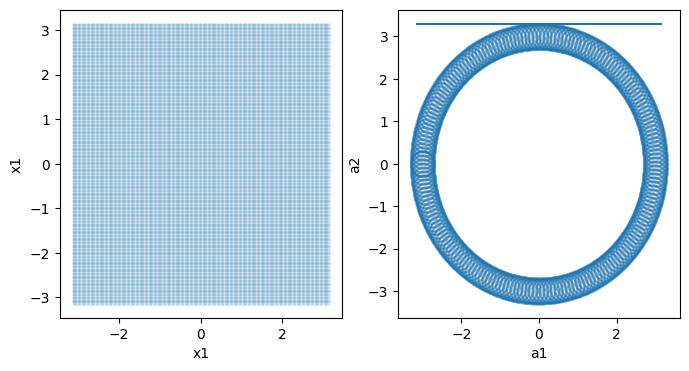

In [43]:
# Look at the mapping function
nx = 200
x1 = np.linspace(-np.pi, np.pi, nx)
x2 = np.linspace(-np.pi, np.pi, nx)

xx1, xx2 = np.meshgrid(x1, x2)

aa1, aa2 = robot_arm(xx1, xx2, 3, 0.3)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

ax[0].scatter(xx1, xx2, s=1, alpha=0.1)
ax[0].set_xlabel("x1")
ax[0].set_ylabel("x1")
ax[1].scatter(aa1, aa2, s=1, alpha=0.1)
ax[1].set_xlabel("a1")
ax[1].set_ylabel("a2")
ax[1].plot(x1, x1*0 + 3.3)

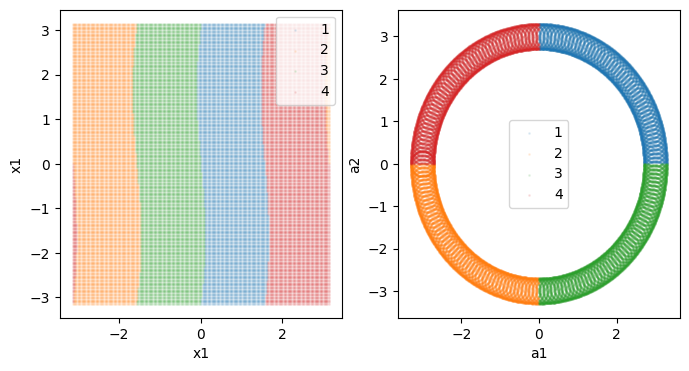

In [44]:
# What x1,x2 map to wich quadrant in a1, a2? These are our classes.

# classes: [+, +], [-, -], [+,-], [-, +] -> 1, 2, 3, 4
class1 = np.where(aa1 > 0, 1, 0)*np.where(aa2 > 0, 1, 0)
class2 = np.where(aa1 < 0, 1, 0)*np.where(aa2 < 0, 1, 0)
class3 = np.where(aa1 > 0, 1, 0)*np.where(aa2 < 0, 1, 0)
class4 = np.where(aa1 < 0, 1, 0)*np.where(aa2 > 0, 1, 0)
classes = {"1":class1, "2":class2, "3":class3, "4":class4}

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

for key in classes.keys() :
    ax[0].scatter(xx1[np.nonzero(classes[key])], xx2[np.nonzero(classes[key])], s=1, alpha=0.1, label=key)
    ax[1].scatter(aa1[np.nonzero(classes[key])], aa2[np.nonzero(classes[key])], s=1, alpha=0.1, label=key)

ax[0].set_xlabel("x1")
ax[0].set_ylabel("x1")
ax[1].set_xlabel("a1")
ax[1].set_ylabel("a2")
ax[0].legend()
ax[1].legend()

Text(0, 0.5, 'a2')

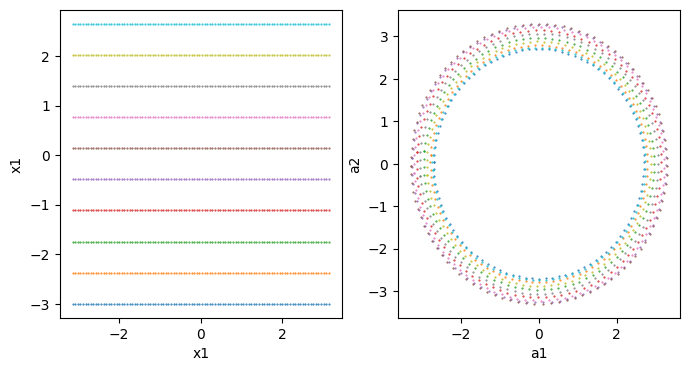

In [45]:
# Look at the mapping function
nx = 100
x1 = np.linspace(-np.pi, np.pi, nx)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
for i in range(lines):
    dx2 = 2*np.pi/lines
    x2 = 0*x1 -3 + i*dx2
    a1, a2 = robot_arm(x1, x2, 3, 0.3)
    ax[0].plot(x1, x2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(a1, a2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("x1")
ax[0].set_ylabel("x1")
ax[1].set_xlabel("a1")
ax[1].set_ylabel("a2")

Text(0, 0.5, 'a2')

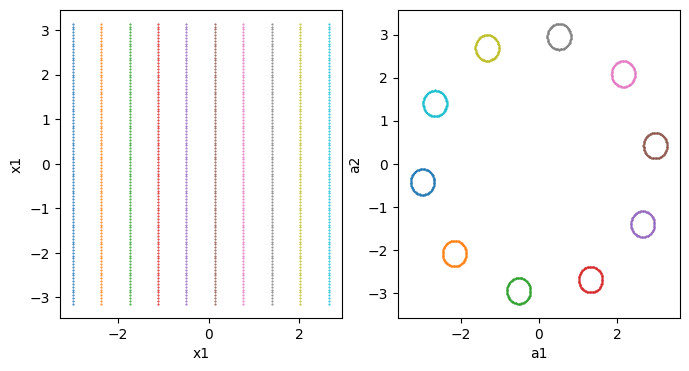

In [46]:
# Look at the mapping function
nx = 100
x2 = np.linspace(-np.pi, np.pi, nx)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))
lines = 10
for i in range(lines):
    dx1 = 2*np.pi/lines
    x1 = 0*x2 -3 + i*dx1
    a1, a2 = robot_arm(x1, x2, 3, 0.3)
    ax[0].plot(x1, x2, marker='.', markersize=1, linestyle='none')
    ax[1].plot(a1, a2, marker='.', markersize=1, linestyle='none')

ax[0].set_xlabel("x1")
ax[0].set_ylabel("x1")
ax[1].set_xlabel("a1")
ax[1].set_ylabel("a2")

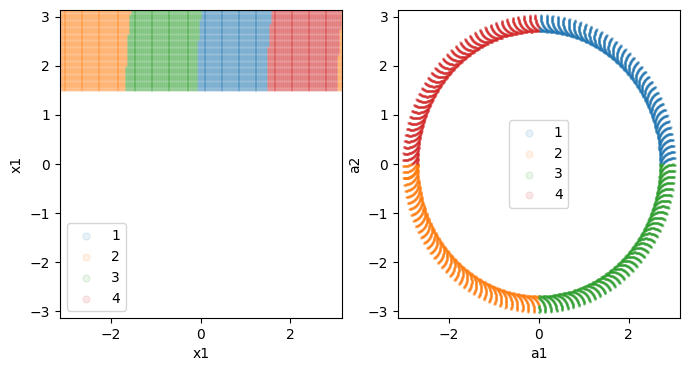

In [47]:
# Look at a subset
nx = 150
x1 = np.linspace(-np.pi, np.pi, nx)
x2 = np.linspace(1.5, np.pi, nx)

xx1, xx2 = np.meshgrid(x1, x2)

aa1, aa2 = robot_arm(xx1, xx2, 3, 0.3)

# classes: [+, +], [-, -], [+,-], [-, +] -> 1, 2, 3, 4
class1 = np.where(aa1 > 0, 1, 0)*np.where(aa2 > 0, 1, 0)
class2 = np.where(aa1 < 0, 1, 0)*np.where(aa2 < 0, 1, 0)
class3 = np.where(aa1 > 0, 1, 0)*np.where(aa2 < 0, 1, 0)
class4 = np.where(aa1 < 0, 1, 0)*np.where(aa2 > 0, 1, 0)
classes = {"1":class1, "2":class2, "3":class3, "4":class4}

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 4))

for key in classes.keys() :
    ax[0].scatter(xx1[np.nonzero(classes[key])], xx2[np.nonzero(classes[key])], s=1, alpha=0.1, label=key)
    ax[1].scatter(aa1[np.nonzero(classes[key])], aa2[np.nonzero(classes[key])], s=1, alpha=0.1, label=key)

ax[0].set_xlabel("x1")
ax[0].set_ylabel("x1")
ax[1].set_xlabel("a1")
ax[1].set_ylabel("a2")
for i in range(len(ax)):
    ax[i].set_xlim(-np.pi, np.pi)
    ax[i].set_ylim(-np.pi, np.pi)
    ax[i].legend(markerscale=5)

In [48]:

# Generate distribution

df_keys = ["c", "x1", "x2", "a1", "a2", "r1", "r2"]
df = pd.DataFrame(columns=df_keys)

rng = np.random.default_rng()
n = 100000 #number of samples per color
R_1 = [5, 3]
R_2 = 1

for i, c in enumerate(["red", "green"]):
    df_temp = pd.DataFrame(columns=df_keys)
    r1 = np.random.normal(R_1[i], 0.3, n)
    r2 = r1*0 + R_2
    df_temp["r1"] = r1
    df_temp["r2"] = r2
    a1 = np.array([random.uniform(0, 2*np.pi) for i in range(n)])
    a2 = np.array([random.uniform(0, np.pi) for i in range(n)])
    df_temp["a1"] = a1
    df_temp["a2"] = a2

    # Get robot arm value
    x1, x2 = robot_arm(a1, a2, r1, r2)
    df_temp["x1"] = x1
    df_temp["x2"] = x2
    df_temp["c"] = c
    df = pd.concat([df, df_temp])


/tmp/ipykernel_45265/877093146.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_temp])


<Axes: xlabel='r1', ylabel='Density'>

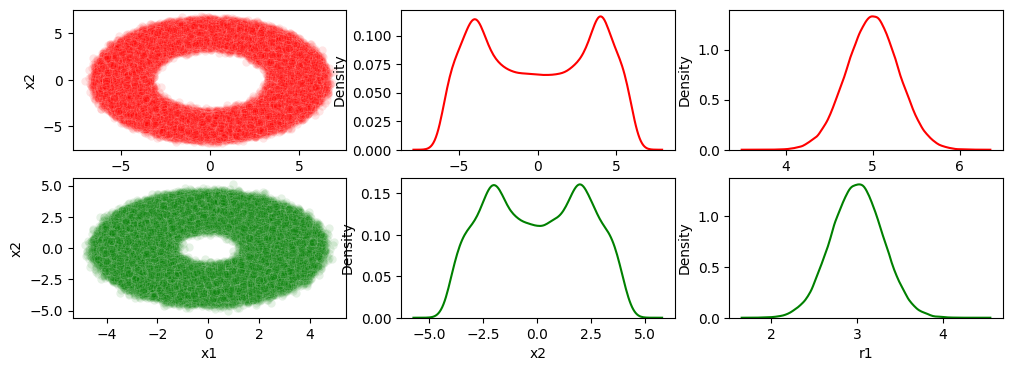

In [49]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 4))
sn.scatterplot(df[df["c"] == "red"], x="x1", y = "x2", c="red", alpha=0.1, ax=ax[0][0])
sn.kdeplot(df[df["c"] == "red"], x="x2", c="red", ax=ax[0][1])
sn.scatterplot(df[df["c"] == "green"], x="x1", y = "x2", c="green", alpha=0.1, ax=ax[1][0])
sn.kdeplot(df[df["c"] == "green"], x="x2", c="green", ax=ax[1][1])
sn.kdeplot(df[df["c"] == "red"], x="r1", c="red", ax=ax[0][2])
sn.kdeplot(df[df["c"] == "green"], x="r1", c="green", ax=ax[1][2])


In [60]:

# Generate training data

df_keys = ["c", "x1", "x2", "a1", "a2", "r1", "r2"]
df_cal = pd.DataFrame(columns=df_keys)
df_train = pd.DataFrame(columns=df_keys)
data = [df_cal, df_train]
R_1 = [5, 3]
R_2 = 1

for j in range(len(data)):
# Generate distribution
    rng = np.random.default_rng()
    n = 200 #number of samples per color
    
    for i, c in enumerate(["red", "green"]):
        df_temp = pd.DataFrame(columns=df_keys)
        r1 = np.random.normal(R_1[i], 0.3, n)
        r2 = r1*0 + R_2
        df_temp["r1"] = r1
        df_temp["r2"] = r2
        a1 = np.array([random.uniform(0, 2*np.pi) for i in range(n)])
        a2 = np.array([random.uniform(0, np.pi) for i in range(n)])
        df_temp["a1"] = a1
        df_temp["a2"] = a2

        # Get robot arm value
        x1, x2 = robot_arm(a1, a2, r1, r2)
        df_temp["x1"] = x1
        df_temp["x2"] = x2
        df_temp["c"] = c
        data[j] = pd.concat([data[j], df_temp])


/tmp/ipykernel_45265/2037868286.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dframe = pd.concat([dframe, df_temp])
/tmp/ipykernel_45265/2037868286.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dframe = pd.concat([dframe, df_temp])


Text(0.5, 0.98, 'Calibration set')

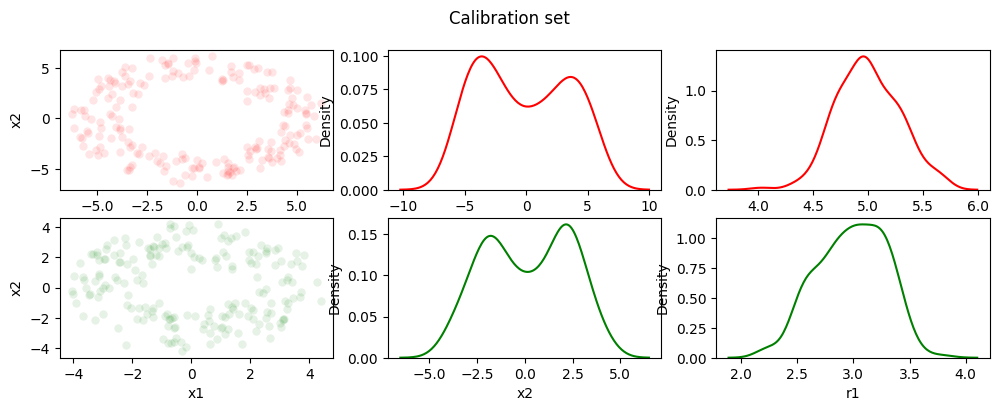

In [51]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 4))
def plot_data(df, ax):
    sn.scatterplot(df[df["c"] == "red"], x="x1", y = "x2", c="red", alpha=0.1, ax=ax[0][0])
    sn.kdeplot(df[df["c"] == "red"], x="x2", c="red", ax=ax[0][1])
    sn.scatterplot(df[df["c"] == "green"], x="x1", y = "x2", c="green", alpha=0.1, ax=ax[1][0])
    sn.kdeplot(df[df["c"] == "green"], x="x2", c="green", ax=ax[1][1])
    sn.kdeplot(df[df["c"] == "red"], x="r1", c="red", ax=ax[0][2])
    sn.kdeplot(df[df["c"] == "green"], x="r1", c="green", ax=ax[1][2])
plot_data(df, ax)
fig.suptitle("Calibration set")

In [52]:

# Generate test data

df_keys = ["c", "x1", "x2", "a1", "a2", "r1", "r2"]
df_test = pd.DataFrame(columns=df_keys)

rng = np.random.default_rng()
n = 1000 #number of samples per color
R_1 = [5, 3]
R_2 = 1

for i, c in enumerate(["red", "green"]):
    df_temp = pd.DataFrame(columns=df_keys)
    r1 = np.random.normal(R_1[i], 0.3, n)
    r2 = r1*0 + R_2
    df_temp["r1"] = r1
    df_temp["r2"] = r2
    a1 = np.array([random.uniform(0, 2*np.pi) for i in range(n)])
    a2 = np.array([random.uniform(0, np.pi) for i in range(n)])
    df_temp["a1"] = a1
    df_temp["a2"] = a2

    # Get robot arm value
    x1, x2 = robot_arm(a1, a2, r1, r2)
    df_temp["x1"] = x1
    df_temp["x2"] = x2
    df_temp["c"] = c
    df_test = pd.concat([df_test, df_temp])


/tmp/ipykernel_45265/3048965153.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_test = pd.concat([df_test, df_temp])


Text(0.5, 0.98, 'Test set')

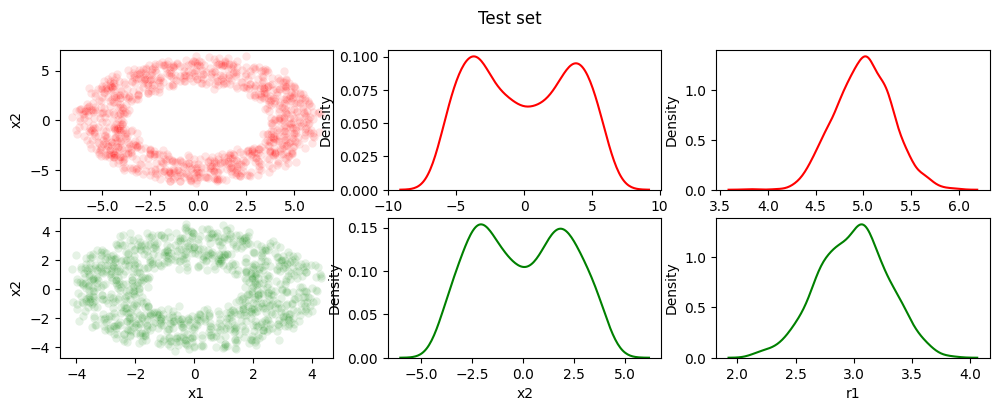

In [53]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 4))
plot_data(df_test, ax)

fig.suptitle("Test set")

In [56]:
df_test

,c,x1,x2,a1,a2,r1,r2
0,red,-4.066141,2.208814,2.468699,2.202731,5.147163,1.0
1,red,3.418217,2.892764,0.682884,3.054410,5.473333,1.0
2,red,2.347071,-4.057473,5.029548,1.837618,4.850752,1.0
3,red,-5.150401,-3.253437,3.650482,0.338282,5.139547,1.0
4,red,-3.660659,5.031003,2.164319,0.222667,5.242618,1.0
...,...,...,...,...,...,...,...
995,green,2.843563,-1.338688,5.521454,1.459614,2.870698,1.0
996,green,-0.498971,1.923959,1.663679,2.817578,2.909910,1.0
997,green,-2.533094,-0.087079,2.797348,1.928074,2.704817,1.0
998,green,2.175331,-0.324852,5.833483,2.429979,2.857574,1.0


In [57]:
# Save data
df_train.to_csv("data/train.csv", index=False)
df_cal.to_csv("data/cal.csv", index=False)
df_test.to_csv("data/test.csv", index=False)